<a href="https://colab.research.google.com/github/ssmehra7/random-test-ankit/blob/main/curvecompletion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.spatial import ConvexHull
import pandas as pd
from collections import defaultdict
from itertools import combinations
from sklearn.linear_model import RANSACRegressor
from sklearn.base import BaseEstimator, RegressorMixin

In [4]:
def load_csv_data(file_path):
    data_frame = pd.read_csv(file_path)  # Using pandas for CSV reading
    line_segments = defaultdict(list)

    for _, row in data_frame.iterrows():
        segment_id = int(row[0])
        x_coord = row[2]
        y_coord = row[3]

        line_segments[segment_id].append((x_coord, y_coord))

    all_polylines = [np.array(points) for points in line_segments.values()]
    return all_polylines

In [5]:
def display_polylines(polylines, title):
    figure, axis = plt.subplots(figsize=(9, 9))

    color_map = plt.get_cmap('tab10')
    num_lines = len(polylines)
    colors = [color_map(i / num_lines) for i in range(num_lines)]

    for polyline, color in zip(polylines, colors):
        axis.plot(polyline[:, 0], polyline[:, 1], marker='o', linewidth=2, color=color)

    axis.set_aspect('equal')
    axis.set_xlabel('X')
    axis.set_ylabel('Y')
    axis.set_title(title)
    plt.grid(True)
    plt.show()

In [6]:
def display_individual_polylines(polylines):
    color_map = plt.get_cmap('tab10')
    num_lines = len(polylines)
    colors = [color_map(i / num_lines) for i in range(num_lines)]

    for idx, (polyline, color) in enumerate(zip(polylines, colors)):
        figure, axis = plt.subplots(figsize=(9, 9))
        axis.plot(polyline[:, 0], polyline[:, 1], marker='o', linewidth=2, color=color)

        axis.set_aspect('equal')
        axis.set_xlabel('X')
        axis.set_ylabel('Y')
        axis.set_title(f'Polyline {idx + 1}')
        plt.grid(True)
        plt.show()

In [7]:
def point_to_line_distance(point, line_start, line_end):
    return np.abs(np.cross(line_end - line_start, point - line_start)) / np.linalg.norm(line_end - line_start)

def is_line_straight(polyline_points, tolerance=0.05):
    if len(polyline_points) < 3:
        return True

    start_point, end_point = polyline_points[0], polyline_points[-1]
    max_dist = max(point_to_line_distance(p, start_point, end_point) for p in polyline_points[1:-1])
    line_length = np.linalg.norm(end_point - start_point)

    return max_dist / line_length < tolerance

def reduce_to_line(polyline_points):
    return np.array([polyline_points[0], polyline_points[-1]])

In [8]:
def circle_fit_error(params, points):
    center_x, center_y, radius = params
    distances = np.sqrt((points[:, 0] - center_x)**2 + (points[:, 1] - center_y)**2)
    return np.sum((distances - radius)**2)

# class CircleModel(BaseEstimator, RegressorMixin):
#     def fit(self, X, y=None):
#         self.center_ = X.mean(axis=0)
#         self.radius_ = np.mean(np.linalg.norm(X - self.center_, axis=1))
#         return self

#     def predict(self, X):
#         return np.linalg.norm(X - self.center_, axis=1)

# def is_circular_shape(points, tolerance=0.05):
#     if len(points) < 5:
#         return False

#     # Fit circle using Nelder-Mead optimization
#     optimized_result = minimize(circle_fit_error,
#                                 x0=[np.mean(points[:, 0]), np.mean(points[:, 1]), np.mean(np.linalg.norm(points - np.mean(points, axis=0), axis=1))],
#                                 args=(points,),
#                                 method='Nelder-Mead')
#     center_x, center_y, radius = optimized_result.x

#     # Calculate distances of all points from the fitted center
#     distances = np.sqrt((points[:, 0] - center_x)**2 + (points[:, 1] - center_y)**2)

#     # Check if all points are roughly at the same distance from the center
#     circularity_ratio = np.std(distances) / radius
#     return circularity_ratio < tolerance

def is_circular_shape(points, tolerance=0.05):
    if len(points) < 5:
        return False

    avg_x, avg_y = np.mean(points, axis=0)
    avg_radius = np.mean(np.linalg.norm(points - [avg_x, avg_y], axis=1))

    optimized_result = minimize(circle_fit_error, [avg_x, avg_y, avg_radius], args=(points,))

    if not optimized_result.success:
        return False

    center_x, center_y, radius = optimized_result.x
    distances_from_center = np.abs(np.sqrt((points[:, 0] - center_x)**2 + (points[:, 1] - center_y)**2) - radius)
    return np.all(distances_from_center < tolerance * radius)

def generate_circle(points):
    avg_x, avg_y = np.mean(points, axis=0)
    avg_radius = np.mean(np.linalg.norm(points - [avg_x, avg_y], axis=1))
    optimized_result = minimize(circle_fit_error, [avg_x, avg_y, avg_radius], args=(points,))
    center_x, center_y, radius = optimized_result.x

    angles = np.linspace(0, 2 * np.pi, 100)
    return np.column_stack((center_x + radius * np.cos(angles), center_y + radius * np.sin(angles)))


In [9]:
def is_rectangular_shape(points, tolerance=0.2):
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]

    if len(hull_points) != 4:
        return False

    # Relaxed Angle Check
    angles = []
    for i in range(4):
        v1 = hull_points[i] - hull_points[i - 1]
        v2 = hull_points[(i + 1) % 4] - hull_points[i]
        angle = angle_between_vectors(v1, v2)
        angles.append(np.degrees(angle))

    angles = np.array(angles)
    angle_deviation = np.abs(angles - 90)

    if not np.all(angle_deviation <= np.degrees(tolerance)):
        return False

    # Relaxed Side Length Check
    side_lengths = [np.linalg.norm(hull_points[i] - hull_points[(i + 1) % 4]) for i in range(4)]
    side_length_ratio_1 = side_lengths[0] / side_lengths[2]
    side_length_ratio_2 = side_lengths[1] / side_lengths[3]

    if not (0.8 <= side_length_ratio_1 <= 1.2 and 0.8 <= side_length_ratio_2 <= 1.2):
        return False

    return True

def generate_rectangle(points):
    hull = ConvexHull(points)
    corners = points[hull.vertices]

    if len(corners) != 4:
        return points

    centroid = np.mean(corners, axis=0)
    angles = np.arctan2(corners[:, 1] - centroid[1], corners[:, 0] - centroid[0])
    corners = corners[np.argsort(angles)]

    return np.vstack((corners, corners[0]))

In [10]:
def optimize_polyline(points):
    if is_line_straight(points):
        return reduce_to_line(points)
    elif is_circular_shape(points):
        return generate_circle(points)
    elif is_rectangular_shape(points):
        return generate_rectangle(points)
    else:
        return points

In [11]:
def compare_and_plot(original, optimized, index):
    figure, (axis1, axis2) = plt.subplots(1, 2, figsize=(12, 6))

    axis1.plot(original[:, 0], original[:, 1], 'b-')
    axis1.set_title(f'Original Polyline {index}')
    axis1.set_aspect('equal', 'box')

    axis2.plot(optimized[:, 0], optimized[:, 1], 'r-')
    axis2.set_title(f'Optimized Polyline {index}')
    axis2.set_aspect('equal', 'box')

    plt.tight_layout()
    plt.show()

In [12]:
def merge_overlapping_circles(optimized_polylines, tolerance=0.1):
    merged_polylines = []
    used_indices = set()

    for i, poly1 in enumerate(optimized_polylines):
        if i in used_indices:
            continue
        combined_polyline = poly1
        for j, poly2 in enumerate(optimized_polylines):
            if j <= i or j in used_indices:
                continue
            if check_circle_overlap(combined_polyline, poly2, tolerance):
                combined_polyline = merge_two_circles(combined_polyline, poly2)
                used_indices.add(j)
        merged_polylines.append(combined_polyline)

    return merged_polylines

def check_circle_overlap(circle1, circle2, tolerance):
    center1, radius1 = circle1.mean(axis=0), np.linalg.norm(circle1[0] - circle1.mean(axis=0))
    center2, radius2 = circle2.mean(axis=0), np.linalg.norm(circle2[0] - circle2.mean(axis=0))

    center_distance = np.linalg.norm(center1 - center2)

    return center_distance < (radius1 + radius2) * tolerance

def merge_two_circles(circle1, circle2):
    combined_points = np.vstack([circle1, circle2])
    hull = ConvexHull(combined_points)
    return generate_circle(combined_points[hull.vertices])

In [13]:
def detect_symmetry(polyline):
    symmetric_axes = []

    centroid = np.mean(polyline, axis=0)
    reflected_horizontal = polyline.copy()
    reflected_horizontal[:, 1] = 2 * centroid[1] - reflected_horizontal[:, 1]

    reflected_vertical = polyline.copy()
    reflected_vertical[:, 0] = 2 * centroid[0] - reflected_vertical[:, 0]

    reflected_diag1 = polyline.copy()
    reflected_diag1[:, [0, 1]] = 2 * centroid - reflected_diag1[:, [1, 0]]

    reflected_diag2 = polyline.copy()
    reflected_diag2[:, 0] = 2 * centroid[1] - reflected_diag2[:, 1]
    reflected_diag2[:, 1] = 2 * centroid[0] - reflected_diag2[:, 0]

    if np.allclose(np.sort(polyline, axis=0), np.sort(reflected_horizontal, axis=0), atol=1e-2):
        symmetric_axes.append('horizontal')
    if np.allclose(np.sort(polyline, axis=0), np.sort(reflected_vertical, axis=0), atol=1e-2):
        symmetric_axes.append('vertical')
    if np.allclose(np.sort(polyline, axis=0), np.sort(reflected_diag1, axis=0), atol=1e-2):
        symmetric_axes.append('diagonal1')
    if np.allclose(np.sort(polyline, axis=0), np.sort(reflected_diag2, axis=0), atol=1e-2):
        symmetric_axes.append('diagonal2')

    return symmetric_axes

def draw_symmetry_lines(polyline, symmetric_axes):
    centroid = np.mean(polyline, axis=0)
    figure, axis = plt.subplots(figsize=(9, 9))
    axis.plot(polyline[:, 0], polyline[:, 1], 'b-', linewidth=2, label="Polyline")

    if 'horizontal' in symmetric_axes:
        axis.axhline(y=centroid[1], color='r', linestyle='--', label="Horizontal Symmetry")
    if 'vertical' in symmetric_axes:
        axis.axvline(x=centroid[0], color='g', linestyle='--', label="Vertical Symmetry")
    if 'diagonal1' in symmetric_axes:
        x_vals = np.array(axis.get_xlim())
        y_vals = centroid[1] + (x_vals - centroid[0])
        axis.plot(x_vals, y_vals, color='purple', linestyle='--', label="Diagonal Symmetry 1")
    if 'diagonal2' in symmetric_axes:
        x_vals = np.array(axis.get_xlim())
        y_vals = centroid[1] - (x_vals - centroid[0])
        axis.plot(x_vals, y_vals, color='orange', linestyle='--', label="Diagonal Symmetry 2")

    axis.set_aspect('equal')
    axis.set_xlabel('X')
    axis.set_ylabel('Y')
    axis.set_title(f'Symmetry Detection')
    plt.legend()
    plt.grid(True)
    plt.show()

<ipython-input-4-6de7d7dfa4d4>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  segment_id = int(row[0])
<ipython-input-4-6de7d7dfa4d4>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_coord = row[2]
<ipython-input-4-6de7d7dfa4d4>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_coord = row[3]


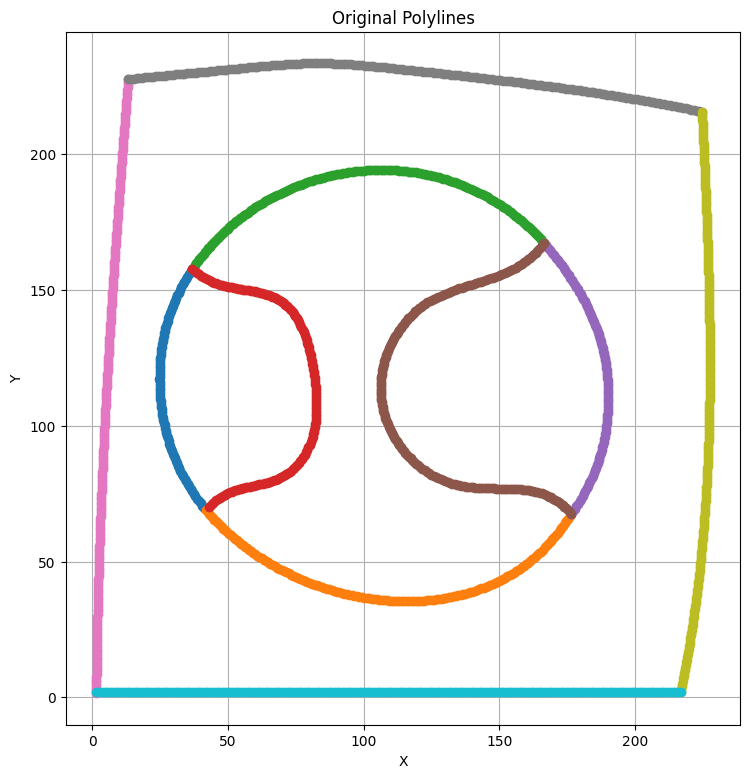

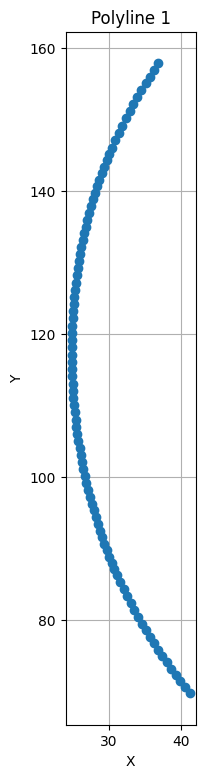

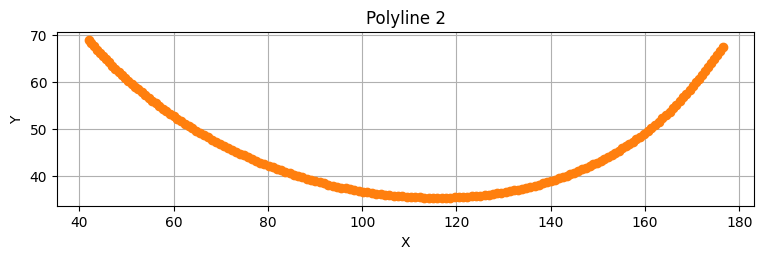

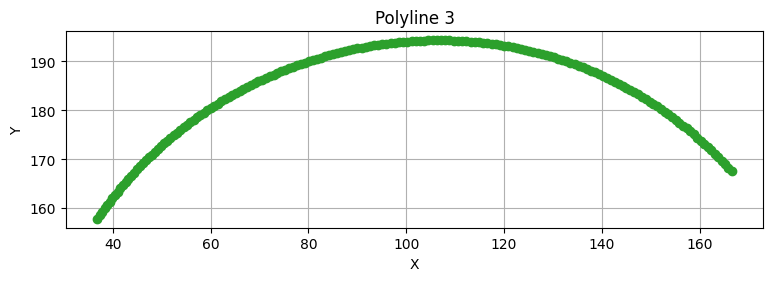

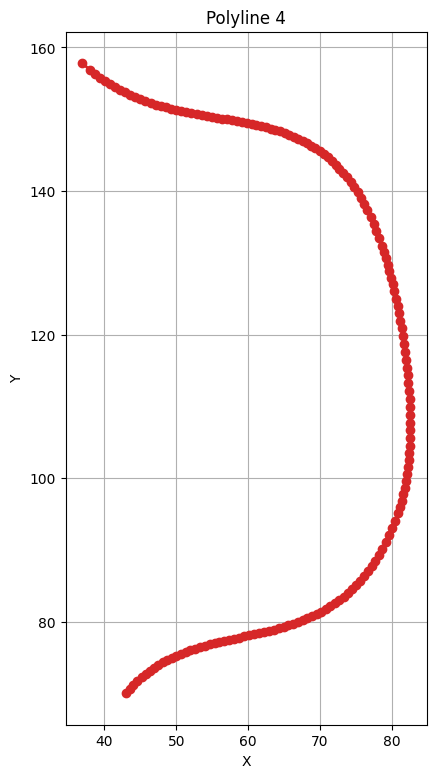

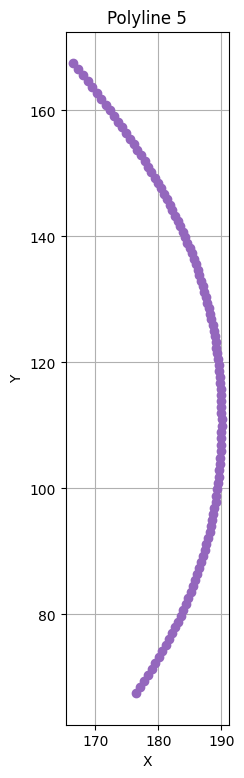

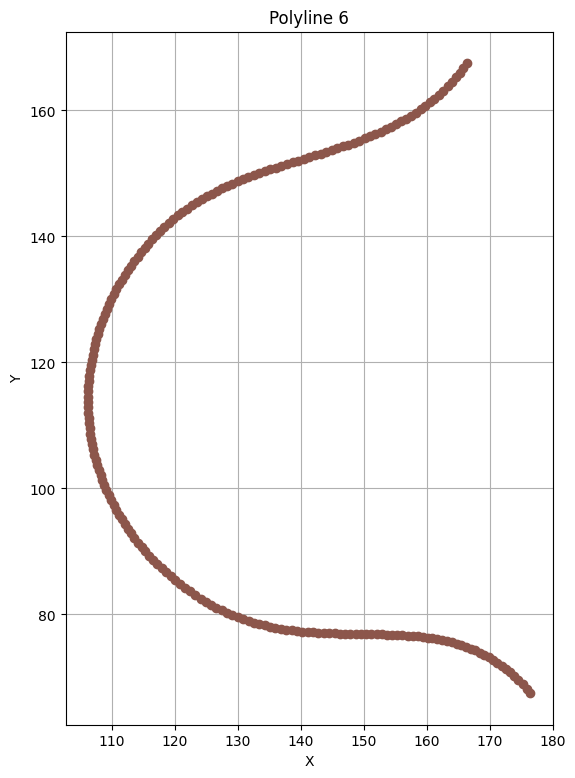

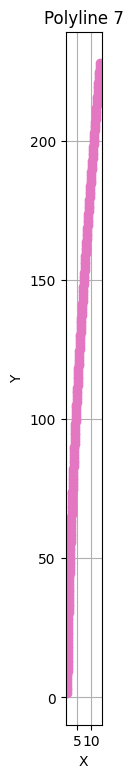

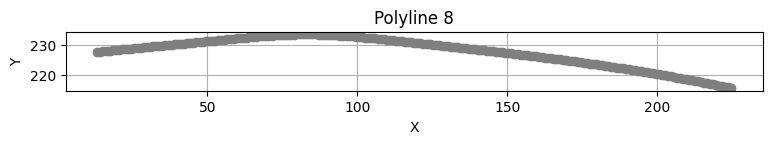

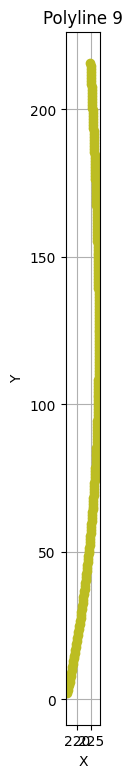

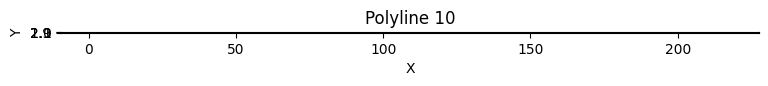

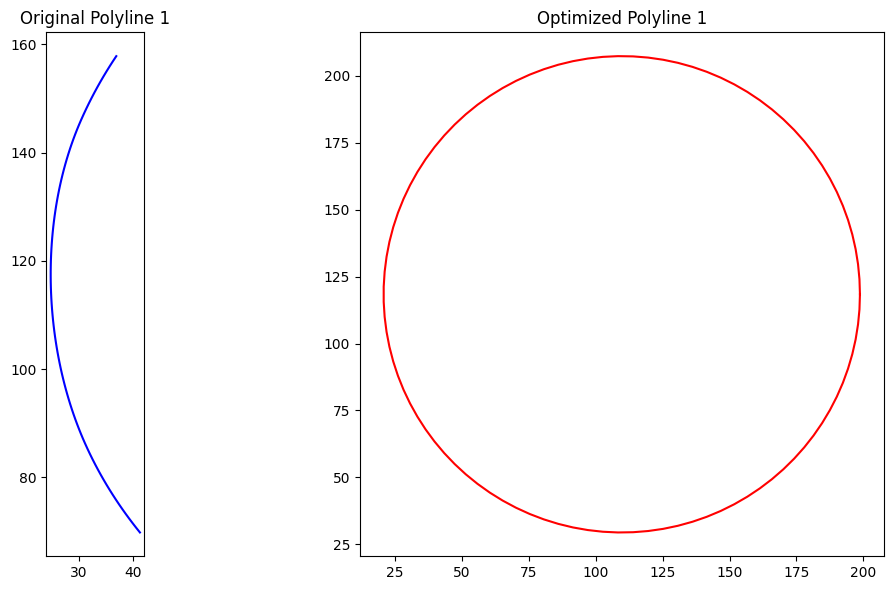

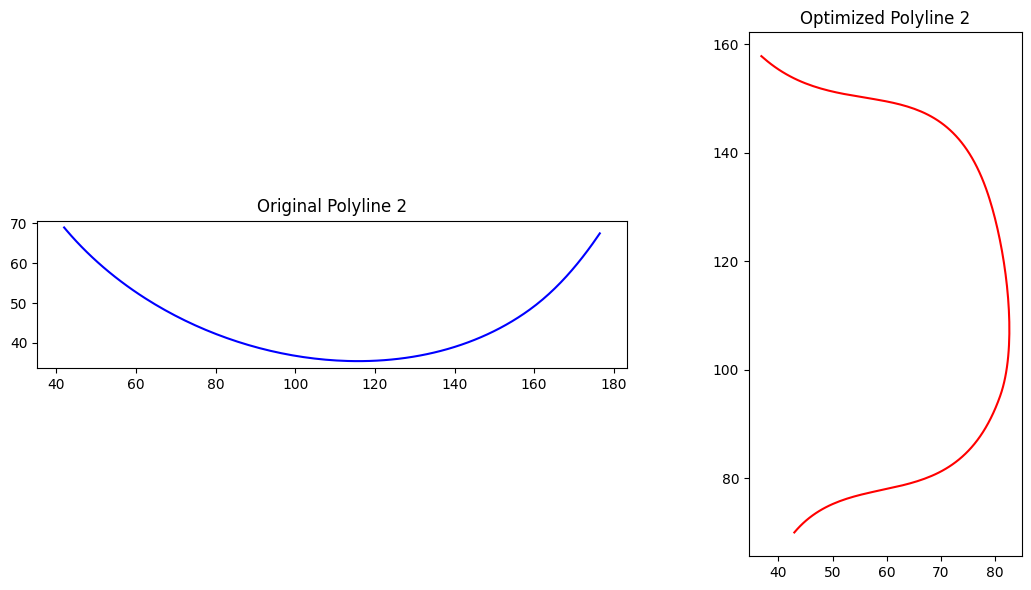

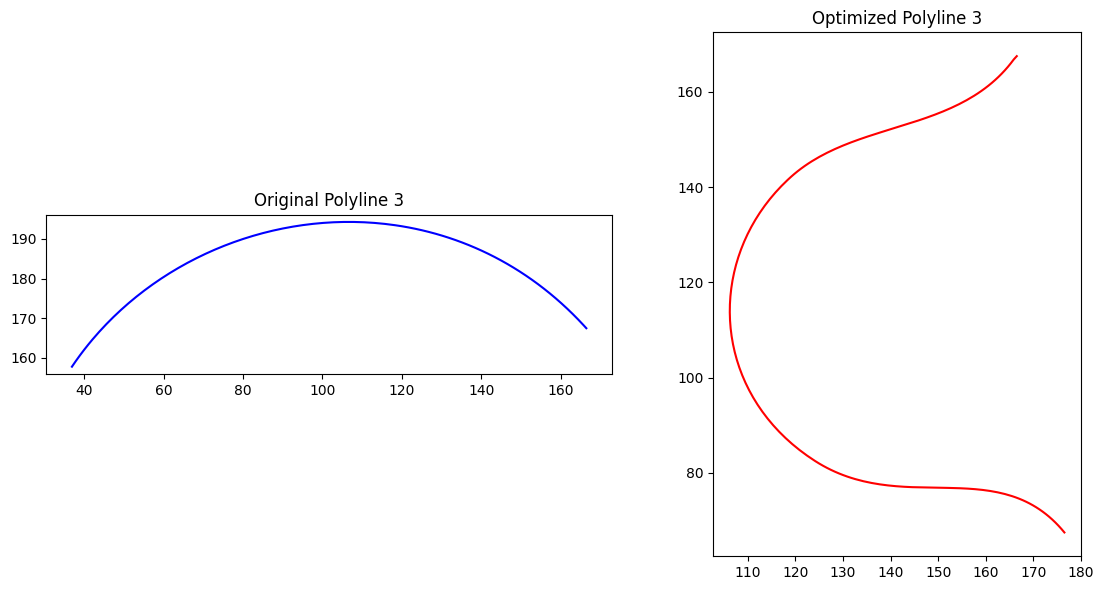

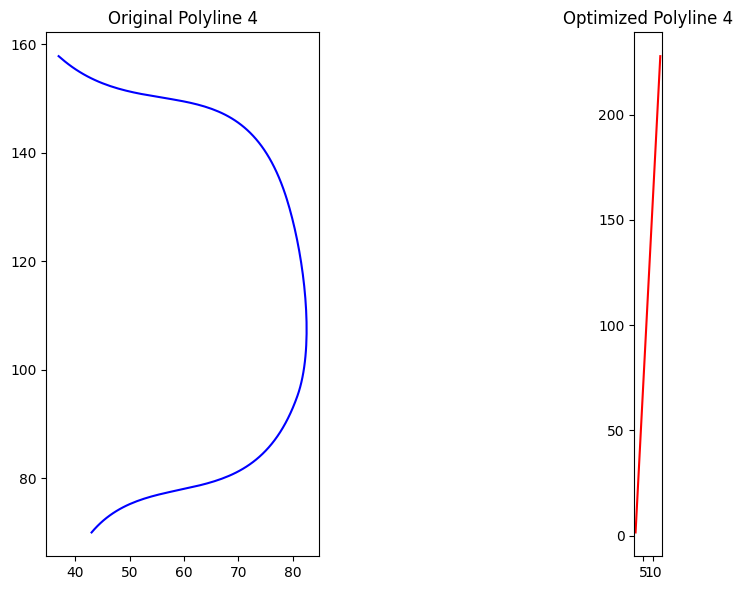

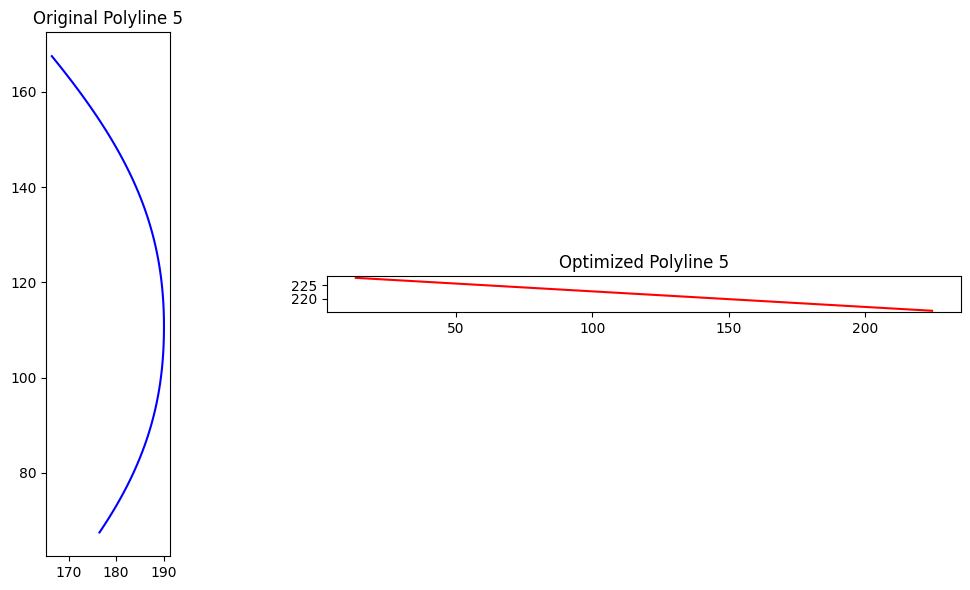

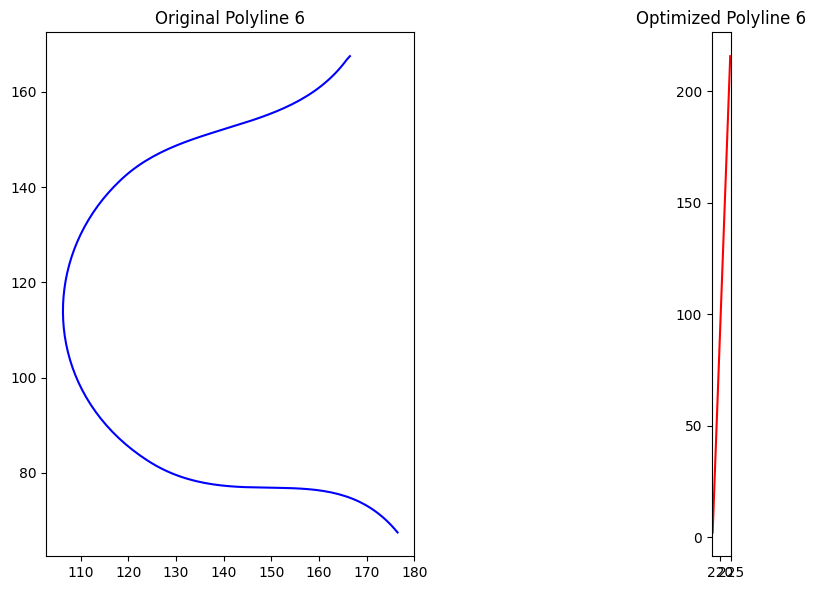

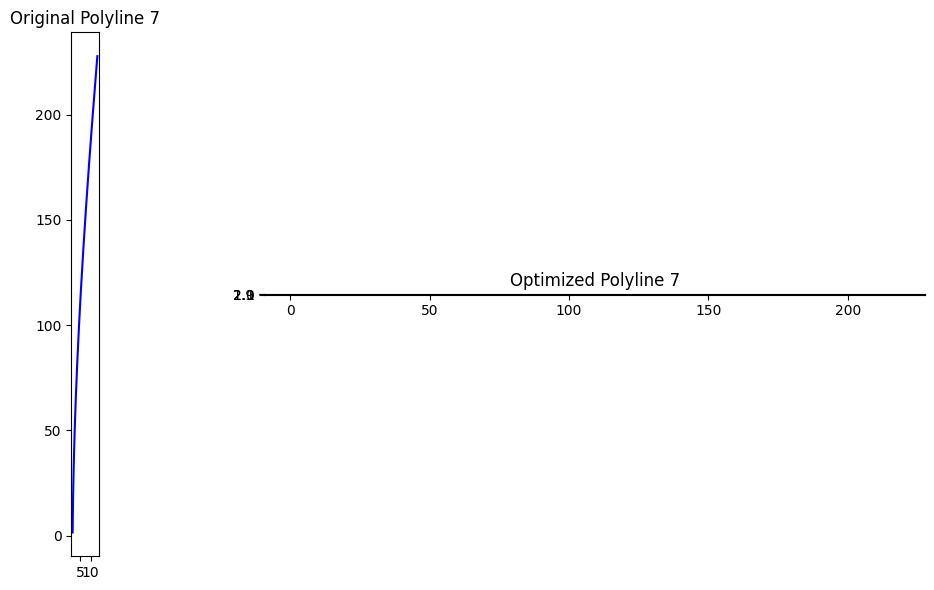

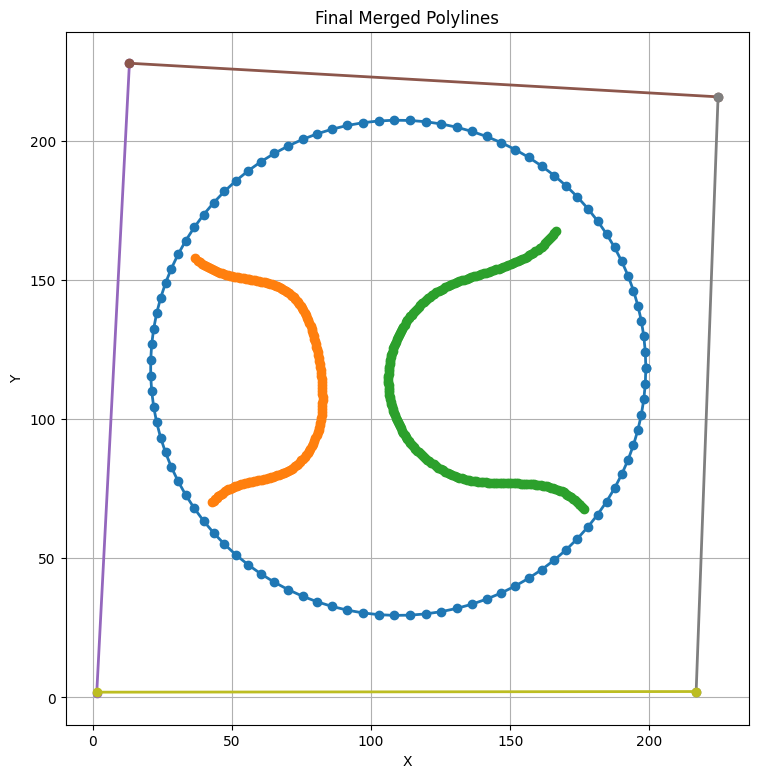

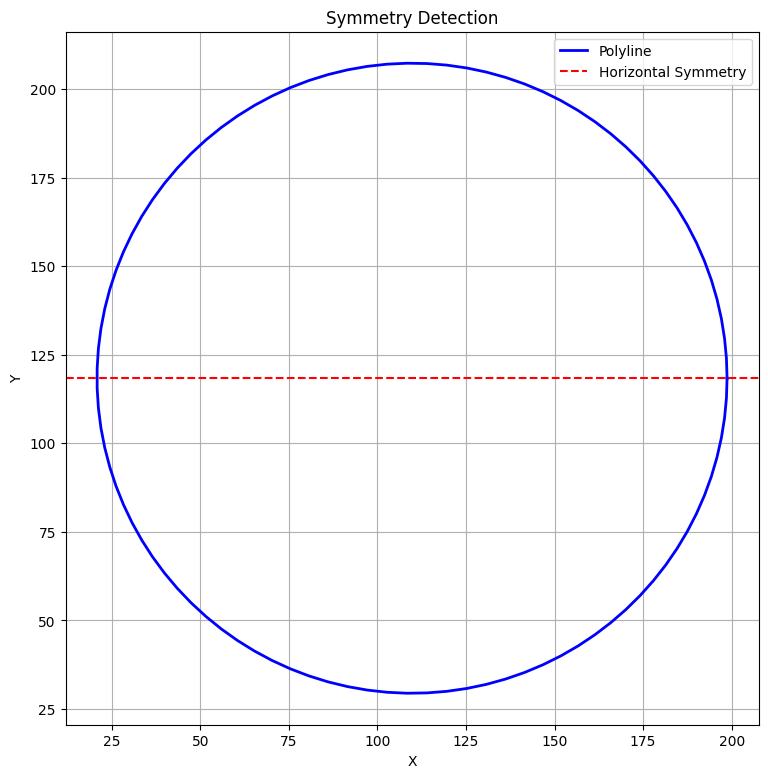

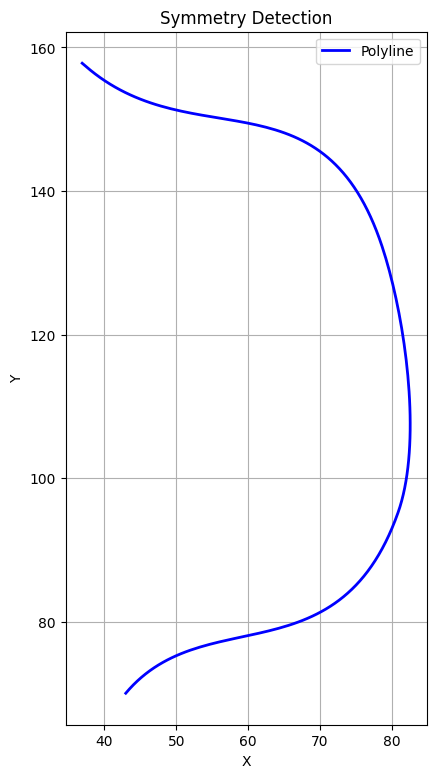

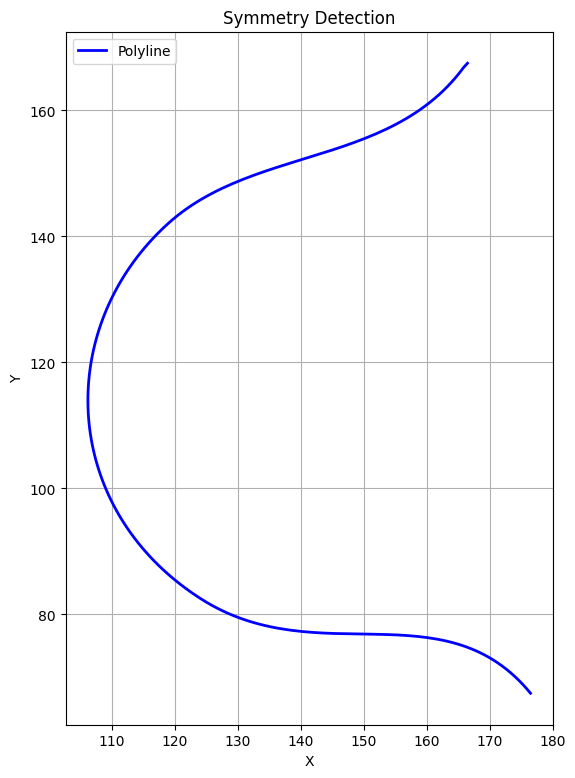

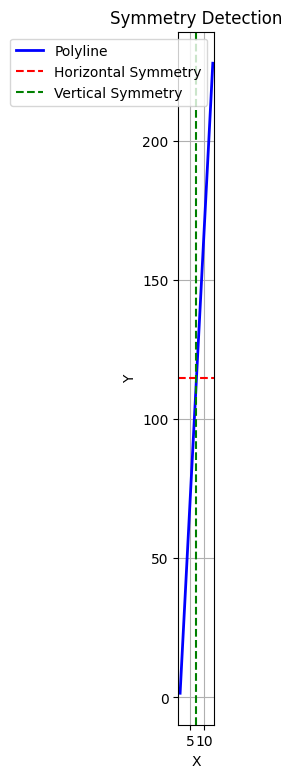

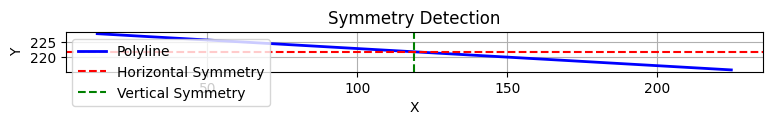

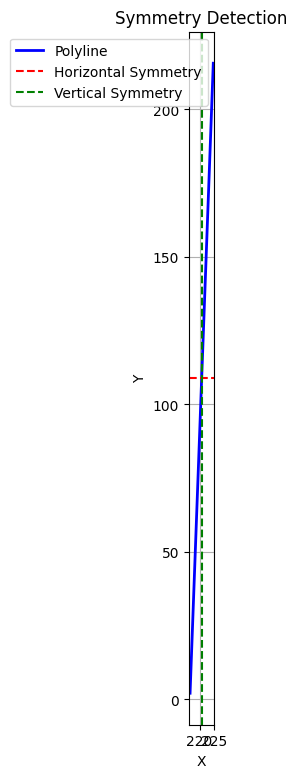

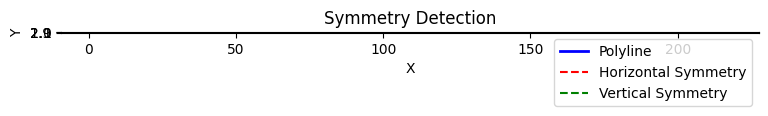

In [19]:

if __name__ == "__main__":
    csv_file_path = '/content/frag0.csv'
    polylines_data = load_csv_data(csv_file_path)

    display_polylines(polylines_data, "Original Polylines")
    display_individual_polylines(polylines_data)

    optimized_polylines = [optimize_polyline(polyline) for polyline in polylines_data]

    final_polylines = merge_overlapping_circles(optimized_polylines)

    for idx, (original, optimized) in enumerate(zip(polylines_data, final_polylines)):
        compare_and_plot(original, optimized, idx + 1)

    display_polylines(final_polylines, "Final Merged Polylines")
    for polyline in final_polylines:
        symmetries = detect_symmetry(polyline)
        draw_symmetry_lines(polyline, symmetries)
